# Comparing the output distirbutions of different Generative Methods

In [1]:
import torch
import numpy as np
import normflows as nf
import os

from matplotlib import pyplot as plt

from tqdm import tqdm

from jet_dataset import JetDataset
from script_jets import DDPM, SimpleCondFF

/beegfs/desy/user/bierings/conda/envs/bayesconda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
###################################
### Define the Normalizing Flow ###
###################################

# Define flows
K = 10

latent_size = 1
hidden_units = 64
hidden_layers = 2
context_size = 16

ep = 7499
flow_dir = './data/NF_2_jets15/'

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(1, trainable=False)
    
# Construct flow model
flow = nf.ConditionalNormalizingFlow(q0, flows)

# Move model on GPU if available
flow = flow.to(device)
flow.eval()

flow.load_state_dict(torch.load(flow_dir + f"model_{ep}.pth"))
print('loaded model from ' + flow_dir + f"model_{ep}.pth")

loaded model from ./data/NF_2_jets15/model_7499.pth


In [4]:
###########################################################
### Define the Normalizing Flow trained on reduced data ###
###########################################################

del_context_1 = ['label_top']

# Define flows
K = 10

latent_size = 1
hidden_units = 64
hidden_layers = 2
context_size = 16 - len(del_context_1)

ep = 5000
flow_dir = './data/NF_jets15_label_top/'

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0_1 = nf.distributions.DiagGaussian(1, trainable=False)
    
# Construct flow model
flow_1 = nf.ConditionalNormalizingFlow(q0_1, flows)

# Move model on GPU if available
flow_1 = flow_1.to(device)
flow_1.eval()

flow_1.load_state_dict(torch.load(flow_dir + f"model_{ep}.pth"))
print('loaded model from ' + flow_dir + f"model_{ep}.pth")

loaded model from ./data/NF_jets15_label_top/model_5000.pth


In [5]:
############################################################
### Define the Normalizing Flow trained on only jet data ###
############################################################

del_context_2 = ['label_top', 'aux_genpart_eta', 'aux_genpart_phi', 'aux_genpart_pid', 'aux_genpart_pt',	'aux_truth_match']

# Define flows
K = 10

latent_size = 1
hidden_units = 64
hidden_layers = 2
context_size = 16 - len(del_context_2)

ep = 5000
flow_dir = './data/NF_jets15_label_top_aux_genpart_eta_aux_genpart_phi_aux_genpart_pid_aux_genpart_pt_aux_truth_match/'

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0_2 = nf.distributions.DiagGaussian(1, trainable=False)
    
# Construct flow model
flow_2 = nf.ConditionalNormalizingFlow(q0_2, flows)

# Move model on GPU if available
flow_2 = flow_2.to(device)
flow_2.eval()

flow_2.load_state_dict(torch.load(flow_dir + f"model_{ep}.pth"))
print('loaded model from ' + flow_dir + f"model_{ep}.pth")

loaded model from ./data/NF_jets15_label_top_aux_genpart_eta_aux_genpart_phi_aux_genpart_pid_aux_genpart_pt_aux_truth_match/model_5000.pth


In [6]:
##################################
### Define the Diffusion Model ###
##################################

n_classes = 10 #have no effect
n_feat = 256 # 128 ok, 256 better (but slower)
n_T = 400 # probably total overkill

ep = 59
diff_dir = './data/diffusion_jets15_great/'

nn_model_class = SimpleCondFF #ContextUnet

ddpm = DDPM(nn_model=nn_model_class(in_channels=1, 
                                    n_feat=n_feat, 
                                    n_classes=n_classes), 
                                    betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)
ddpm.eval()

ddpm.load_state_dict(torch.load(diff_dir + f"model_{ep}.pth"))
print('loaded model from ' + diff_dir + f"model_{ep}.pth")

loaded model from ./data/diffusion_jets15_great/model_59.pth


In [7]:
#######################
### Define the data ###
#######################

['label_top' 'jet_pt' 'jet_eta' 'jet_phi' 'jet_energy' 'jet_nparticles'
 'jet_sdmass' 'jet_tau1' 'jet_tau2' 'jet_tau3' 'jet_tau4'
 'aux_genpart_eta' 'aux_genpart_phi' 'aux_genpart_pid' 'aux_genpart_pt'
 'aux_truth_match']
1.0
1.0
1.0


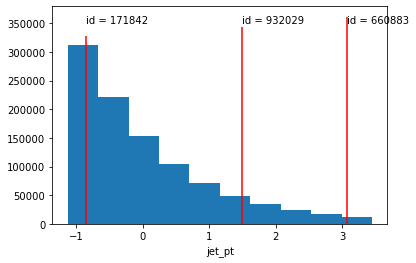

In [8]:
##################################################
### get validation from the distribution tails ###
##################################################

dataset_val = JetDataset("./jet_data", 'val')
labels = np.array(dataset_val.data.keys())[2:]

print(labels)

plt.hist(dataset_val.features[:,1])
plt.xlabel(labels[1])


sort = np.argsort(dataset_val.features[:,1])
for i in [200003, -100005, -10000]:
    plt.vlines(dataset_val.features[sort[i],1], *plt.ylim(), color = 'red', label='target')
    plt.text(dataset_val.features[sort[i],1], 350000, f'id = {sort[i]}')
    print(dataset_val.features[sort[i],0])

[[ 1.0000000e+00  5.3019922e+02 -4.2814437e-01 -5.3884111e-02
   6.0647028e+02  4.0000000e+01]]


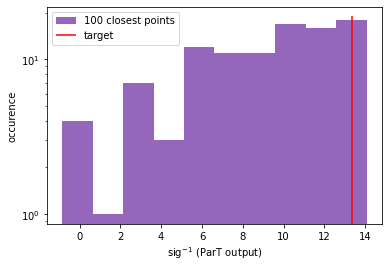

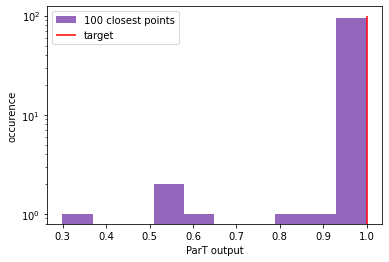

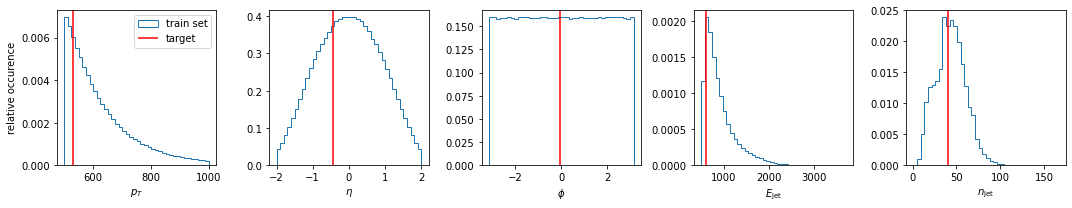

[[ 1.0000000e+00  7.8620898e+02 -5.0841230e-01 -6.5807164e-01
   9.0537335e+02  3.6000000e+01]]


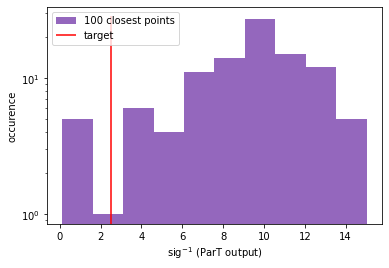

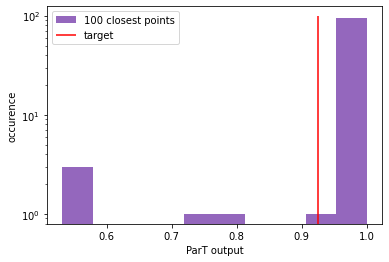

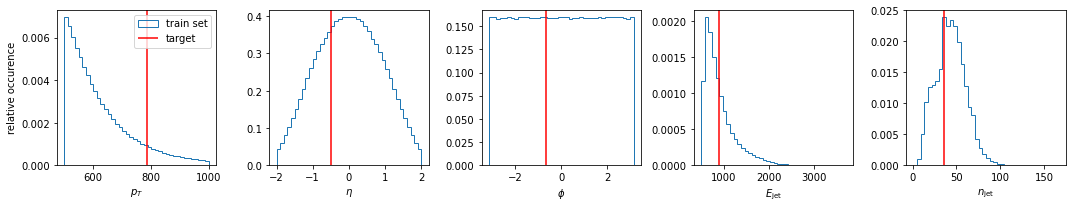

[[ 1.0000000e+00  9.5916376e+02 -1.3223848e-01  4.4869393e-01
   9.8198114e+02  3.9000000e+01]]


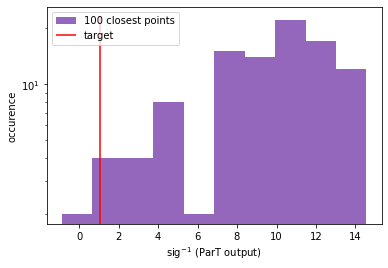

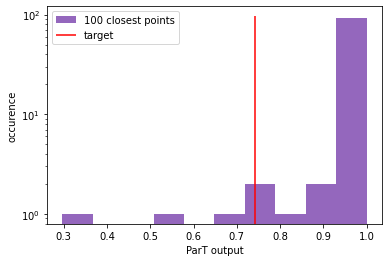

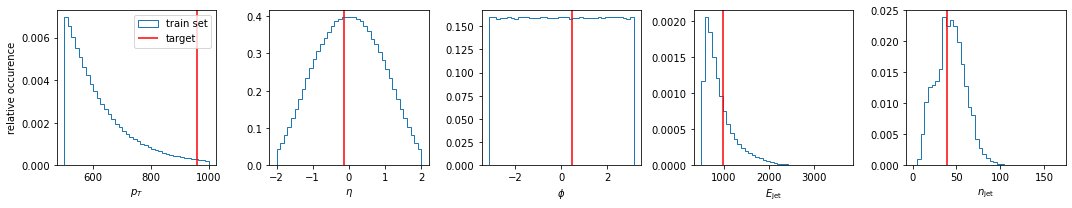

In [9]:
n_plot = 100
#n_stat_alea = 500

color = 'C4'

dont_use = ['jet_sdmass', 
            'jet_tau1',	'jet_tau2',	'jet_tau3',	'jet_tau4',
            'aux_genpart_eta', 'aux_genpart_phi', 'aux_genpart_pid', 'aux_genpart_pt', 'aux_truth_match']

for k in [200003, -100005, -10000]:
    dataset_train = JetDataset("./jet_data", 'train', del_context=dont_use)
    conditions_train = np.array(dataset_train.features)

    dataset_val = JetDataset("./jet_data", 'val', del_context=dont_use)
    conditions = np.array(dataset_val.features)
    sort_tmp = np.argsort(dataset_val.features[:,1])
    i = sort_tmp[k]

    print(conditions[i]*dataset_val.std_norm + dataset_val.means_norm)

    dist_tmp = np.sqrt(np.sum(((conditions_train-conditions[i])**2), axis=1))
    sort = np.argsort(dist_tmp)
    x_data = torch.Tensor(dataset_train.target[sort[:n_plot]]*20)
    _,b,_ = plt.hist(x_data.numpy(), label = f'{n_plot} closest points', color= color)

    #dataset_val = JetDataset("./jet_data",'val')
    #conditions = torch.Tensor(dataset_val.features).to(device)
    #bins = np.linspace(-20,20,40)

    # x_gen_flow, _ = flow.sample(1*n_stat_alea, context=conditions[i:i+1].repeat_interleave(n_stat_alea, dim=0))
    # x_gen_flow = torch.sigmoid(20*x_gen_flow)
    # _,b,_ = plt.hist(x_gen_flow.detach().cpu().numpy(), bins = b, histtype = 'step', label = 'Flow')
    # del x_gen_flow

    # x_gen_diff, _ = ddpm.sample(conditions[i:i+1].repeat_interleave(n_stat_alea, dim=0), device = device)
    # x_gen_diff = torch.sigmoid(20*x_gen_diff)
    # plt.hist(x_gen_diff.detach().cpu().numpy(), bins = b, histtype = 'step', label = 'Diffusion')
    # del x_gen_diff

    # dataset_val = JetDataset("./jet_data",'val', del_context=del_context_1)
    # conditions = torch.Tensor(dataset_val.features).to(device)
    # x_gen_flow, _ = flow_1.sample(1*n_stat_alea, context=conditions[i:i+1].repeat_interleave(n_stat_alea, dim=0))
    # x_gen_flow *= 20
    # _,b,_ = plt.hist(x_gen_flow.detach().cpu().numpy(), bins = b, histtype = 'step', label = 'Flow w/o truth')
    # del x_gen_flow
    
    # dataset_val = JetDataset("./jet_data",'val', del_context=del_context_2)
    # conditions = torch.Tensor(dataset_val.features).to(device)
    # x_gen_flow, _ = flow_2.sample(1*n_stat_alea, context=conditions[i:i+1].repeat_interleave(n_stat_alea, dim=0))
    # x_gen_flow *= 20
    # _,b,_ = plt.hist(x_gen_flow.detach().cpu().numpy(), bins = b, histtype = 'step', label = 'Flow only jet')
    # del x_gen_flow

    x_target = torch.Tensor(dataset_val.target[i:i+1]*20)
    plt.vlines(x_target.numpy(), *plt.ylim(), color = 'red', label='target')
    plt.yscale('log')
    plt.xlabel(r'$\mathrm{sig}^{-1}$ (ParT output)')
    plt.ylabel('occurence')
    plt.legend()
    plt.savefig(f'./out_{i}.pdf')
    plt.show()

    _,b,_ = plt.hist(torch.sigmoid(x_data).numpy(), label = f'{n_plot} closest points', color= color)
    plt.vlines(torch.sigmoid(x_target).numpy(), *plt.ylim(), color = 'red', label='target')
    plt.yscale('log')
    plt.xlabel(r'ParT output')
    plt.ylabel('occurence')
    plt.legend()
    plt.savefig(f'./out_{i}_sigmoid.pdf')
    plt.show()

    titles = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E_\mathrm{jet}$', r'$n_\mathrm{jet}$', ]
    fig, ax = plt.subplots(1, conditions.shape[1]-1, figsize = (15,3))
    for j, a in enumerate(ax):
        _,b,_ = ax[j].hist(conditions_train[:,j+1]*dataset_train.std_norm[:,j+1] + dataset_train.means_norm[:,j+1],
                    histtype = 'step', density = True, bins = 40, label='train set')
        #ax[j].hist(conditions_train[sort[:n_plot],j+1]*dataset_train.std_norm[:,j+1] + dataset_train.means_norm[:,j+1],
        #            color = color, density = True, bins = b, label = f'{n_plot} closest points')
        ax[j].vlines(conditions[i,j+1]*dataset_val.std_norm[:,j+1] + dataset_val.means_norm[:,j+1],
                      *ax[j].get_ylim(), color = 'red', label='target')
        ax[j].set_xlabel(titles[j])
        ax[j].set_ylim(ax[j].get_ylim()[0], ax[j].get_ylim()[1]*0.95)

    ax[0].legend()
    ax[0].set_ylabel('relative occurence')
    plt.tight_layout()
    plt.savefig(f'./out_{i}_neighbors.pdf')
    plt.show()


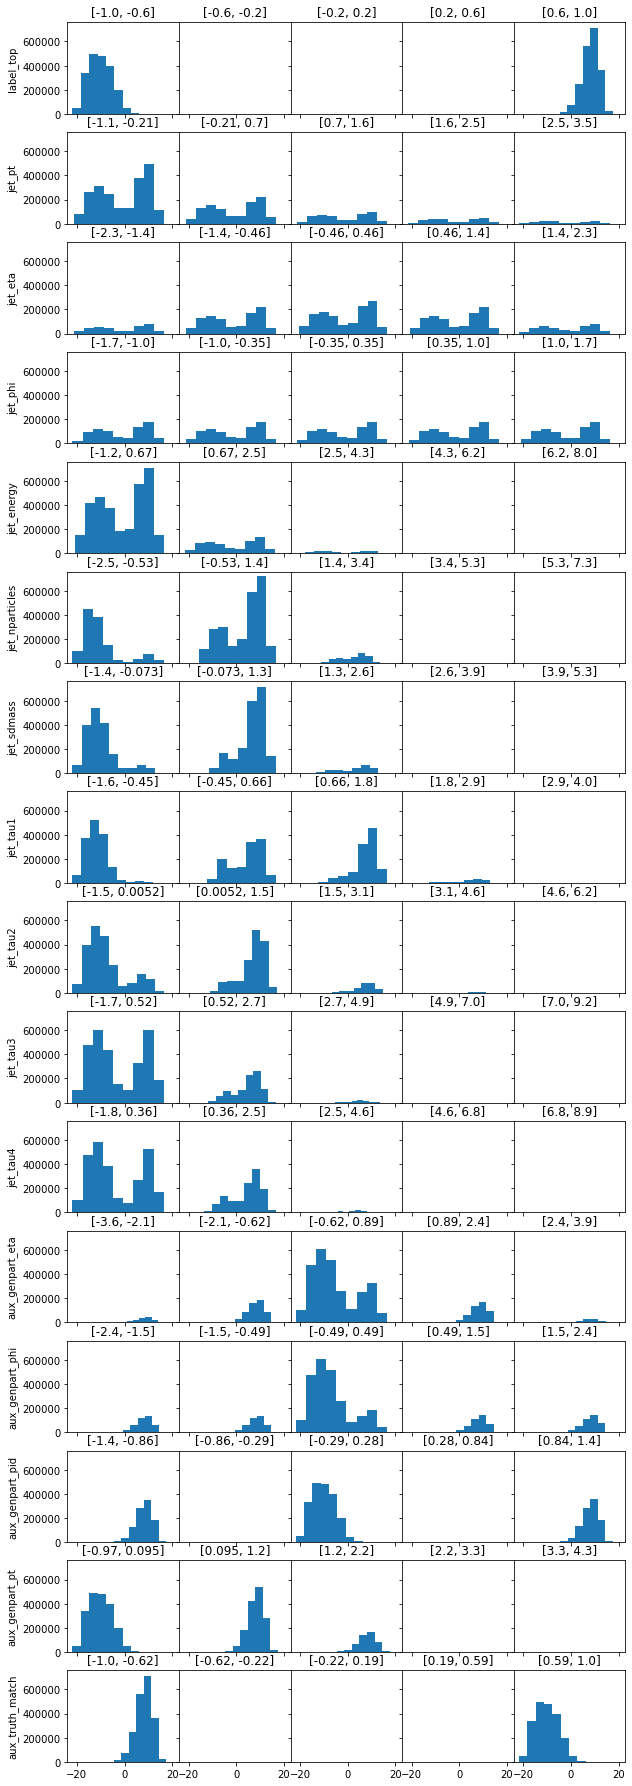

In [10]:
#plot over input bins

n_bins = 5
dataset_train = JetDataset("./jet_data",'train')
labels = np.array(dataset_train.data.keys())[2:]

fig, ax = plt.subplots(dataset_train.features.shape[1], n_bins, figsize = (2*n_bins, 2*dataset_train.features.shape[1]), sharex=True, sharey=True)

for i_f in range(dataset_train.features.shape[1]):
    print(i_f, end = '\r')
    bins = np.linspace(dataset_train.features[:,i_f].min(), dataset_train.features[:,i_f].max(), n_bins+1)

    for i_b in range(n_bins):

        mask = np.bitwise_and(dataset_train.features[:,i_f]>=bins[i_b], dataset_train.features[:,i_f]<=bins[i_b+1])
        ax[i_f,i_b].hist(dataset_train.target[mask]*20)
        ax[i_f,0].set_ylabel(labels[i_f])
        ax[i_f,i_b].set_title(f'[{bins[i_b]:3.2}, {bins[i_b+1]:3.2}]')

fig.subplots_adjust(wspace=0.)

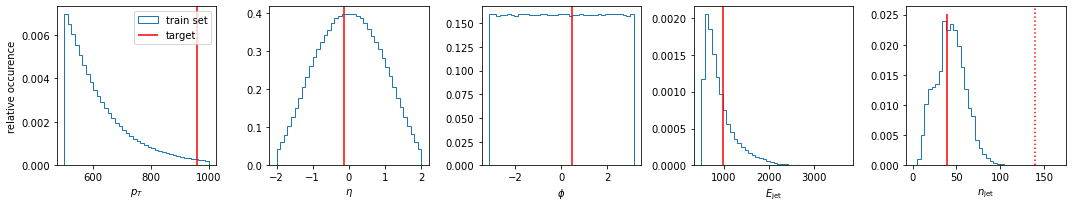

In [16]:
n_plot = 100
#n_stat_alea = 500

color = 'C4'


k = -10000

dont_use = ['jet_sdmass', 
            'jet_tau1',	'jet_tau2',	'jet_tau3',	'jet_tau4',
            'aux_genpart_eta', 'aux_genpart_phi', 'aux_genpart_pid', 'aux_genpart_pt', 'aux_truth_match']

dataset_train = JetDataset("./jet_data", 'train', del_context=dont_use)
conditions_train = np.array(dataset_train.features)

dataset_val = JetDataset("./jet_data", 'val', del_context=dont_use)
conditions = np.array(dataset_val.features)
sort_tmp = np.argsort(dataset_val.features[:,1])
i = sort_tmp[k]

#mask_top = dataset_train.features[:,0] ==1
#mask_ntop = dataset_train.features[:,0] !=1

titles = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E_\mathrm{jet}$', r'$n_\mathrm{jet}$', ]
fig, ax = plt.subplots(1, conditions.shape[1]-1, figsize = (15,3))
for j, a in enumerate(ax):
    _,b,_ = ax[j].hist(conditions_train[:,j+1]*dataset_train.std_norm[:,j+1] + dataset_train.means_norm[:,j+1],
                histtype = 'step', density = True, bins = 40, label='train set')
    ax[j].vlines(conditions[i,j+1]*dataset_val.std_norm[:,j+1] + dataset_val.means_norm[:,j+1],
                    *ax[j].get_ylim(), color = 'red', label='target')
    if j == 4:
        conditions[:,j+1] = (conditions[:,j+1]*dataset_val.std_norm[0,j+1]+100)/dataset_val.std_norm[0,j+1]
        ax[j].vlines(conditions[i,j+1]*dataset_val.std_norm[:,j+1] + dataset_val.means_norm[:,j+1],
            *ax[j].get_ylim(), color = 'red', linestyle = ':')
    ax[j].set_xlabel(titles[j])
    ax[j].set_ylim(ax[j].get_ylim()[0], ax[j].get_ylim()[1]*0.95)

ax[0].legend()
ax[0].set_ylabel('relative occurence')
plt.tight_layout()
plt.savefig(f'./out_{i}_neighbors_shift.pdf')
plt.show()
